In [174]:
import numpy as np
import os

from matplotlib import pyplot as plt

import pydot

import imageio

import glob

from IPython.display import SVG, display

from pydrake.common import temp_directory
from pydrake.geometry import (
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Role,
    StartMeshcat,
)

from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import ModelVisualizer
from pydrake.systems.primitives import LogVectorOutput
from pydrake.systems.primitives import ConstantVectorSource
from pydrake.systems.controllers import PidController
from pydrake.multibody.tree import RigidBody, UnitInertia, SpatialInertia

test_mode = True if "TEST_SRCDIR" in os.environ else False

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [312]:
# Define a simple cylinder model.
pendulum_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="pendulum">
    <pose>0 0 1.1 0.9 0 0</pose>
    <link name = "pendulum_link">
      <inertial>
        <mass>0.1</mass>
      </inertial>
      <visual name="base">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>0.5</length>
          </cylinder>
        </geometry>
      </visual>
      <collision name="base_col">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>0.5</length>
          </cylinder>
        </geometry>
      </collision>
    </link>

    <link name = "pendulum_link_2">
      <pose>0 0 -0.5 0 0 0</pose>
      <inertial>
        <mass>0.1</mass>
      </inertial>
      <visual name="base">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>0.5</length>
          </cylinder>
        </geometry>
      </visual>
      <collision name="base_col">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>0.5</length>
          </cylinder>
        </geometry>
      </collision>
    </link>

    <joint name="upper_pin_to_lower_pin_joint" type="revolute">
      <parent>pendulum_link</parent>
      <child>pendulum_link_2</child>
      <pose>0 0 0.25 0 0 0</pose>
      <axis>
        <!-- spins about x axis -->
        <xyz>1 0 0</xyz>
      </axis>
    </joint>


  </model>
</sdf>
"""

    # <joint name="world_to_upper_pin_joint" type="revolute">
    #   <parent>world</parent>
    #   <child>pendulum_link</child>
    #   <pose>0 0 0.25 0 0 0</pose>
    #   <axis>
    #     <!-- spins about x axis -->
    #     <xyz>1 0 0</xyz>
    #   </axis>
    # </joint>

table_top_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="table_top">
    <link name="table_top_link">
      <visual name="visual">
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <box>
            <size>2.0 2.0 0.05</size>
          </box>
        </geometry>
        <material>
         <diffuse>0.9 0.8 0.7 1.0</diffuse>
        </material>
      </visual>
      <collision name="collision">
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <box>
            <size>2.0 2.0 0.05</size>
          </box>
        </geometry>
      </collision>
    </link>
    <frame name="table_top_center">
      <pose relative_to="table_top_link">0 0 0 0 0 0</pose>
    </frame>

    <joint name="world_to_table_joint" type="fixed">
      <parent>world</parent>
      <child>table_top_link</child>
      <pose>0 0 0 0 0 0</pose>
    </joint> 
  </model>
</sdf>

"""

# Visualize the cylinder from the SDFormat string you just defined.
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModelsFromString(pendulum_sdf, "sdf")
visualizer.parser().AddModelsFromString(table_top_sdf, "sdf")

# Click the "Stop Running" button in MeshCat when you're finished.
visualizer.Run(loop_once=test_mode)

Click 'Stop Running' or press Esc to quit


<RunResult.STOPPED: 2>

In [313]:
builder = DiagramBuilder()
meshcat.Delete()
meshcat.DeleteAddedControls()

sim_time_step = 0.001
plant, scene_graph = AddMultibodyPlantSceneGraph(
    builder, time_step = sim_time_step
)

parser = Parser(plant)
parser.AddModelsFromString(pendulum_sdf, 'sdf')
parser.AddModelsFromString(table_top_sdf, 'sdf')

plant.Finalize()


plant_context = plant.CreateDefaultContext()
zero_torque = builder.AddSystem(ConstantVectorSource([0.]))
builder.Connect(
    zero_torque.get_output_port(),
    plant.get_actuation_input_port())


visualizer = MeshcatVisualizer.AddToBuilder(
    builder, scene_graph, meshcat,
    MeshcatVisualizerParams(role = Role.kPerception, prefix="visual")
)

logger = LogVectorOutput(plant.get_state_output_port(), builder)
logger.set_name("logger")

diagram = builder.Build()


# display(SVG(pydot.graph_from_dot_data(
#         diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

simulator = Simulator(diagram)

sim_context = diagram.GetMutableSubsystemContext(
    plant, simulator.get_mutable_context()
)
# sim_context.SetDiscreteState(np.array([1., 0., 0., 0.]))

# visualizer.PublishRecording

In [314]:
pendulum_link_1 = plant.GetRigidBodyByName("pendulum_link")
RigidBody.SetMass(pendulum_link_1, sim_context, 0.2)

pendulum_link_2 = plant.GetRigidBodyByName("pendulum_link_2")
RigidBody.SetMass(pendulum_link_2, sim_context, 1.0)


simulator = Simulator(diagram)

sim_context = diagram.GetMutableSubsystemContext(
    plant, simulator.get_mutable_context()
)
# sim_context.SetDiscreteState(np.array([1.5, 0., 0., 0.]))

simulator.Initialize()
simulator.set_target_realtime_rate(1,)

visualizer.StartRecording()
simulator.AdvanceTo(2.0)
# visualizer.PublishRecording

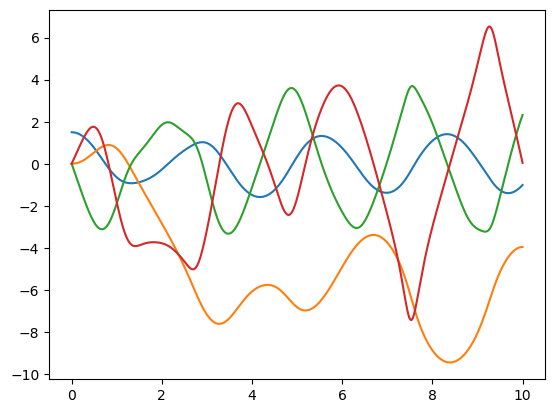

In [180]:
log = logger.FindLog(simulator.get_context())
t = log.sample_times()

plt.figure()
plt.plot(t, log.data()[0,:])
plt.plot(t, log.data()[1,:])
plt.plot(t, log.data()[2,:])
plt.plot(t, log.data()[3,:])

In [379]:
def generate_trajectory(params):
    end_time = 1.0

    simulator = Simulator(diagram)

    sim_context = diagram.GetMutableSubsystemContext(
        plant, simulator.get_mutable_context()
    )
    sim_context.SetDiscreteState(np.array([1., 0., 0., 0., 0., 0., 1.0, 0., 0., 0., 0., 2., 0., 0., 0.,]))

    pendulum_link_1 = plant.GetRigidBodyByName("pendulum_link")
    
    unit_inertia = UnitInertia.SolidCylinder(params[0], params[1])
    mass = 1.0
    com = [0, 0, 0]
    spatial_inertia = SpatialInertia(mass, com, unit_inertia)

    RigidBody.SetSpatialInertiaInBodyFrame(pendulum_link_1, sim_context, spatial_inertia)

    pendulum_link_2 = plant.GetRigidBodyByName("pendulum_link_2")

    unit_inertia = UnitInertia.SolidCylinder(params[2], params[3])
    mass = 0.2
    com = [0, 0, 0]
    spatial_inertia = SpatialInertia(mass, com, unit_inertia)

    RigidBody.SetSpatialInertiaInBodyFrame(pendulum_link_2, sim_context, spatial_inertia)
    # RigidBody.SetMass(pendulum_link_2, sim_context, params[1])

    simulator.Initialize()
    simulator.set_target_realtime_rate(0,)

    visualizer.StartRecording()
    simulator.AdvanceTo(end_time)

    log = logger.FindLog(simulator.get_context())

    return log.data()


ref_params = [0.1, 1.0, 0.1, 1.0]
ref_trajectory = generate_trajectory(ref_params)

# Mean squared error between two arrays
def mse(array_1, array_2):
    array_1 = array_1.flatten()
    array_2 = array_2.flatten()
    difference_array = np.subtract(array_1, array_2)
    squared_array = np.square(difference_array)
    mse = squared_array.mean()

    print(mse)

    return mse

# Calculate the cost of a specific set of parameters
def calc_param_cost(params):

    new_trajectory = generate_trajectory(params)
    # current_cost = mse(ref_trajectory, new_trajectory)

    return mse(ref_trajectory, new_trajectory)

In [385]:
cost = []
params = []

def make_plot(num):
  params_plot = np.array(params)

  plt.figure(figsize=[10,5], dpi=150)
  plt.subplot(223)
  plt.plot(cost, label = "error")
  plt.legend()

  plt.subplot(224)

  plt.hlines(ref_params, 0, len(cost))

  for i in range(len(params_plot[0])):
      plt.plot(params_plot[:, i], label = i)
    
  plt.legend()

  plt.subplot(221)
  plt.title("Original Trajectory")
  plt.plot(ref_trajectory[0,:])
  plt.plot(ref_trajectory[1,:])
  plt.plot(ref_trajectory[2,:])
  plt.plot(ref_trajectory[3,:])
  plt.plot(ref_trajectory[4,:])
  plt.plot(ref_trajectory[5,:])
  plt.plot(ref_trajectory[6,:])
  plt.plot(ref_trajectory[7,:])

  plt.subplot(222)
  plt.title("Trial Trajectory")
  final_trajectory = generate_trajectory(opt.current_parameters)
  plt.plot(final_trajectory[0,:])
  plt.plot(final_trajectory[1,:])
  plt.plot(final_trajectory[2,:])
  plt.plot(final_trajectory[3,:])
  plt.plot(final_trajectory[4,:])
  plt.plot(final_trajectory[5,:])
  plt.plot(final_trajectory[6,:])
  plt.plot(final_trajectory[7,:])

  #plt.show()
  plt.savefig(f'./plots/plt-{str(num).zfill(3)}.png')
  plt.close()

In [391]:
from stochastic_optimzer import StochasticOptimizer

opt = StochasticOptimizer()

opt.set_initial_parameters(np.array([0.5, 0.5, 0.5, 0.5]))
opt.set_parameter_range(np.array([4., 4., 4., 4.]),
                        np.array([0.01,  0.01, 0.01, 0.01]))

opt.set_calc_cost(calc_param_cost)

for i in range(500):
    
    cost.append(opt.calc_cost(opt.current_parameters))
    params.append(opt.current_parameters.copy())

    if(not i % 20):
      make_plot(i)

    opt.perform_step()


0.2707774954972127
0.26169418422085816
0.26169418422085816
0.2559874674409667
0.2559874674409667
0.25498861817276613
0.25498861817276613
0.25718268906204433
0.25498861817276613
0.2529911693578879
0.2529911693578879
0.2500621752854028
0.2500621752854028
0.25595676726079514
0.2500621752854028
0.2553377393808419
0.2500621752854028
0.25411326215002167
0.2500621752854028
0.24856758663716305
0.24856758663716305
0.25134099075854516
0.24856758663716305
0.2506466809036623
0.24856758663716305
0.2510820965385498
0.24856758663716305
0.24829679952149927
0.24829679952149927
0.25008360992432166
0.24829679952149927
0.26371343622922055
0.24829679952149927
0.24918258226852685
0.24829679952149927
0.24914441449017152
0.24829679952149927
0.2493650352772156
0.24829679952149927
0.24489280829540788
0.24489280829540788
0.2486821678051289
0.24489280829540788
0.24426229809749653
0.24426229809749653
0.24549234212330553
0.24426229809749653
0.24532534201391235
0.24426229809749653
0.2462706001833277
0.24426229809749

In [392]:


# make_plot(0)

images = sorted(glob.glob("./plots/*"))

with imageio.get_writer('line.gif', mode='i') as writer:
    for image in images:
        image = imageio.imread(image)
        writer.append_data(image)

/var/folders/6g/b9gn6mc97zqfm_7v0202jt580000gn/T/ipykernel_80085/683832267.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image)
